## Importing libraries

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import ast
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


## Dealing with movies dataframe

In [119]:
def remove_unused_movies_columns(movies_df):
    " Remove unused columns from movies dataframe"
    movies_df.drop(['adult', 'belongs_to_collection', 'homepage','poster_path', 'tagline', 'status', 'video'], axis=1, inplace=True)
    return movies_df
    
def parsing_movies_data(movies_df):
    "Cleans datetime and id columns"
    movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
    movies_df['id'] = movies_df['id'].apply(lambda x: x.replace('-','0'))
    movies_df['id'] = movies_df['id'].astype(int)

movies_df = pd.read_csv('../../data/movies_metadata.csv')
remove_unused_movies_columns(movies_df)
parsing_movies_data(movies_df)

/var/folders/kl/0bp0fbpx63d_shndfsfhypp40000gn/T/ipykernel_28022/2184189558.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('../../data/movies_metadata.csv')


### Merging movies, credits and keywords dataframes

In [120]:
credits_df = pd.read_csv('../../data/credits.csv')
keywords_df = pd.read_csv('../../data/keywords.csv')

merged_df = pd.merge(movies_df, credits_df, on='id', how="inner")
merged_df = pd.merge(merged_df, keywords_df, on='id', how="inner")

merged_df = merged_df.drop_duplicates(subset='id', keep='first')

## Looking for null values and dealing with them

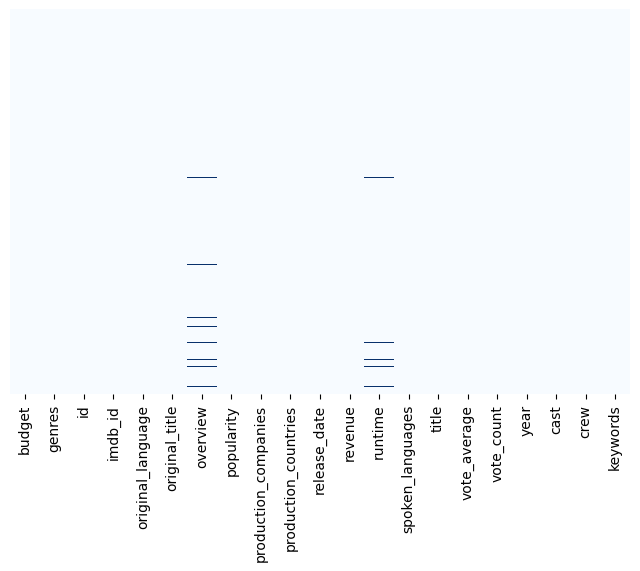

In [121]:
plt.figure(figsize=(8,5))
sns.heatmap(merged_df.isnull(),cmap='Blues',cbar=False,yticklabels=False)

merged_df['overview'] = merged_df['overview'].fillna('')
merged_df['runtime'] = merged_df['runtime'].fillna(0)

## Reshaping to a database format

In [122]:
genres_set = set();
genders_map = {
    '0': 'unkown',
    '1': 'female',
    '2': 'male'
}
properties_map = {
    'keyword': {
        'data': [],
        'middle_data': [],
        'set': set(),
        'get_mdl_data_info': lambda data, movie_id: {
            'keyword_id': data['id'],
            'name': data['name'],
            'movie_id': movie_id
        },
        'get_main_data_info': lambda data: {
            'id': data['id'],
            'name': data['name'],
        },
    },
    'genre': {
        'data': [],
        'middle_data': [],
        'set': set(),
        'get_mdl_data_info': lambda data, movie_id: {
            'genre_id': data['id'],
            'name': data['name'],
            'movie_id': movie_id
        },
        'get_main_data_info': lambda data: {
            'id': data['id'],
            'name': data['name'],
        },
    },
    'cast': {
        'data': [],
        'middle_data': [],
        'set': set(),
        'get_mdl_data_info': lambda data, movie_id: {
            'id': data['credit_id'],
            'name': data['name'],
            'movie_id': movie_id,
            'character': data['character'],
            'gender': genders_map[str(data['gender'])],
            'order': data['order'],
            'performer_id': data['id']
        },
        'get_main_data_info': lambda data: {
            'id': data['id'],
            'name': data['name'],
            'gender': genders_map[str(data['gender'])],
        },
    }
}

def increment_lists(data, movie_id, type):
    if type not in ['keyword', 'genre', 'cast']:
        raise ValueError(f'the argument {type} for type is not allowed')
    
    mdl_data_info = properties_map[type]['get_mdl_data_info'](data, movie_id)
    properties_map[type]['middle_data'].append(mdl_data_info)
    
    if data['id'] in  properties_map[type]['set']:
        return

    properties_map[type]['set'].add(data['id'])
    
    main_data_info = properties_map[type]['get_main_data_info'](data)
    properties_map[type]['data'].append(main_data_info)
    
for _, row in merged_df.iterrows():
    genres = ast.literal_eval(row['genres']) if isinstance(row['genres'], str) else []
    keywords = ast.literal_eval(row['keywords']) if isinstance(row['keywords'], str) else []
    casts = ast.literal_eval(row['cast']) if isinstance(row['cast'], str) else []
    movie_id = row['id']
    
    for keyword in keywords:
        increment_lists(keyword, movie_id, type='keyword')
    
    for genre in genres:
        increment_lists(genre, movie_id, type='genre')
        
    for cast in casts:
        increment_lists(cast, movie_id, type='cast')

genres_df = pd.DataFrame(properties_map['genre']['data'])
movie_genres_df = pd.DataFrame(properties_map['genre']['middle_data'])
keywords_df = pd.DataFrame(properties_map['keyword']['data'])
movie_keywords_df = pd.DataFrame(properties_map['keyword']['middle_data'])
performers_df = pd.DataFrame(properties_map['cast']['data'])
casts_df = pd.DataFrame(properties_map['cast']['middle_data'])

## Final adjustments on movies dataframe

In [125]:
def extract_name_from_json(data_list):
    try:
        parsed_data = ast.literal_eval(data_list)
        if isinstance(parsed_data, list) and len(parsed_data) > 0:
            return parsed_data[0]['name']
        else:
            return '-'
    except (SyntaxError, ValueError, KeyError):
        return '-'

merged_df['production_company'] = merged_df['production_companies'].apply(extract_name_from_json)
merged_df['production_country'] = merged_df['production_countries'].apply(extract_name_from_json)
merged_df['spoken_language'] = merged_df['spoken_languages'].apply(extract_name_from_json)
movies = merged_df.drop(['genres', 'production_countries', 'production_companies', 'spoken_languages', 'cast', 'crew', 'keywords'], axis=1)


,budget,id,imdb_id,original_language,original_title,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,year,production_company,production_country,spoken_language
0,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995.0,Pixar Animation Studios,United States of America,English
1,65000000,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,1995.0,TriStar Pictures,United States of America,English
2,0,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0,1995.0,Warner Bros.,United States of America,English
3,16000000,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0,1995.0,Twentieth Century Fox Film Corporation,United States of America,English
4,0,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0,1995.0,Sandollar Productions,United States of America,English
